In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [2]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.

['corpus_txt\\Doyle_AScandalinBohemia.txt',
 'corpus_txt\\Doyle_AStudyinScarlet.txt',
 'corpus_txt\\Doyle_TheHoundoftheBaskervilles.txt',
 'corpus_txt\\Doyle_TheSignoftheFour.txt',
 'corpus_txt\\Howard_GodsoftheNorth.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [3]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

['Doyle_AScandalinBohemia',
 'Doyle_AStudyinScarlet',
 'Doyle_TheHoundoftheBaskervilles',
 'Doyle_TheSignoftheFour',
 'Howard_GodsoftheNorth']

#### Corpus laden

In [4]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [5]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

#### Create Dictionaries

In [6]:
id_types, doc_ids = pre.create_dictionaries(doc_labels, doc_tokens)

#### Sparse BOW Model

In [7]:
sparse_bow = pre.create_mm(doc_labels, doc_tokens, id_types, doc_ids)

In [8]:
sparse_bow[:5]

0
doc_id token_id     
1      16384       1
       16388       1
       8197      244
       4103        1
       8203        1

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [9]:
pre.save_bow_mm(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [10]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [11]:
mm = MmCorpus("gensim_txt.mm")

In [12]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [13]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "de.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [14]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

In [15]:
len(features_to_be_removed)

75

In [16]:
pre.save_bow_mm(sparse_bow_short, "gensim_txt")

In [17]:
mm = MmCorpus("gensim_txt.mm")

#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [18]:
doc2bow_list = pre.make_doc2bow_list(sparse_bow_short)

In [19]:
len(doc2bow_list)

17

In [20]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

In [21]:
model.get_document_topics(doc2bow_list[1])

[(1, 0.13228416239327814),
 (5, 0.18926606754891051),
 (6, 0.32090231624688376),
 (15, 0.13312014179482362),
 (17, 0.18113449370015158),
 (18, 0.016185686387508974),
 (19, 0.013475572672369885)]

In [22]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['smudge',
 'seasoned',
 'boulder-sprinkled',
 'refreshing',
 'vindictiveness',
 'compounded',
 'lil',
 'mauvais',
 'destroyer',
 'unimaginable']

In [23]:
#Topic probabilities
topics = model.show_topics(num_topics = 40)
topics

[(0,
  '0.000*"vegetablelike" + 0.000*"logic" + 0.000*"strikes" + 0.000*"two-dimensional" + 0.000*"ransom" + 0.000*"pigmentation" + 0.000*"squelching" + 0.000*"stockwell" + 0.000*"dispirited" + 0.000*"oldest"'),
 (1,
  '0.007*"smudge" + 0.005*"seasoned" + 0.005*"boulder-sprinkled" + 0.004*"refreshing" + 0.004*"vindictiveness" + 0.004*"compounded" + 0.004*"lil" + 0.004*"mauvais" + 0.004*"destroyer" + 0.004*"unimaginable"'),
 (2,
  '0.000*"vegetablelike" + 0.000*"self-possession" + 0.000*"wednesday" + 0.000*"two-dimensional" + 0.000*"stockwell" + 0.000*"unimaginable" + 0.000*"cool" + 0.000*"refreshing" + 0.000*"pigmentation" + 0.000*"domes"'),
 (3,
  '0.000*"depravity" + 0.000*"shiny-strong" + 0.000*"logic" + 0.000*"outlined" + 0.000*"ransom" + 0.000*"squelching" + 0.000*"police-sergeant" + 0.000*"pigmentation" + 0.000*"haunch" + 0.000*"oldest"'),
 (4,
  '0.000*"strikes" + 0.000*"haunch" + 0.000*"sculptureless" + 0.000*"ransom" + 0.000*"lil" + 0.000*"vegetablelike" + 0.000*"honeycombings

In [24]:
topics_df = pre.gensim2dataframe(model)

In [25]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,vegetablelike,smudge,vegetablelike,depravity,strikes,stockwell,depravity,heel-rope,pigmentation,honeycombings,moth,self-possession,pigmentation,juncture,self-possession,pendulous,lush,indulged,haunch,half-carrying
1,logic,seasoned,self-possession,shiny-strong,haunch,police-sergeant,haunch,pigmentation,domes,self-possession,gravitating,two-dimensional,depravity,disarranged,sculptureless,snarled,flyers,domes,exclamation,cloudily
2,strikes,boulder-sprinkled,wednesday,logic,sculptureless,vegetablelike,two-dimensional,refreshing,logic,lil,domes,outlined,self-possession,stretch,two-dimensional,films,brook,two-dimensional,billow,doomed
3,two-dimensional,refreshing,two-dimensional,outlined,ransom,understand!i,poltoos,candelabrum,haunch,oldest,unastronomical,shred,shred,two-dimensional,stockwell,logic,consequences,honeycombings,dried,screws
4,ransom,vindictiveness,stockwell,ransom,lil,oldest,squelching,logic,lil,police-sergeant,attempts,haunch,vegetablelike,outfits,oldest,decade,official-looking,pigmentation,glimpse,two-dimensional
5,pigmentation,compounded,unimaginable,squelching,vegetablelike,haunch,shred,lil,squelching,squelching,drawling,vegetablelike,strikes,hideously,logic,remarkable-looking,corroborative,weighty,jumpy,strikes
6,squelching,lil,cool,police-sergeant,honeycombings,domes,ransom,sculptureless,self-possession,stockwell,powerfully,stockwell,outlined,mine-sweepers,outlined,mars,russian,guardedly,dispirited,nasal
7,stockwell,mauvais,refreshing,pigmentation,oldest,plumstead,vegetablelike,metal-colored,police-sergeant,strikes,police-sergeant,squelching,candelabrum,nothwendig,vegetablelike,pigmentation,panted,self-possession,gladness,pigmentation
8,dispirited,destroyer,pigmentation,haunch,refreshing,swears,self-possession,unimaginable,ransom,vegetablelike,bows,mine-sweepers,two-dimensional,blasphemously,dispirited,ancestors,wails,powerfully,petra,day's
9,oldest,unimaginable,domes,oldest,police-sergeant,cyclopean,outlined,noisy,oldest,sculptureless,salted,poltoos,stockwell,deaths,haunch,deposit,broadcloth,refreshing,flounce,feverish


In [26]:
doc_topic_matrix_gensim = pre.make_doc_topic_matrix(model, doc2bow_list, doc2id)

In [27]:
doc_topic_matrix_gensim

,Doyle_AScandalinBohemia,Doyle_AStudyinScarlet,Doyle_TheHoundoftheBaskervilles,Doyle_TheSignoftheFour,Howard_GodsoftheNorth,Howard_SchadowsinZamboula,Howard_ShadowsintheMoonlight,Howard_TheDevilinIron,Kipling_TheEndofthePassage,Kipling_TheJungleBook,Kipling_ThyServantaDog,Lovecraft_AttheMountainofMadness,Lovecraft_TheShunnedHouse,Poe_EurekaAProsePoem,Poe_TheCaskofAmontillado,Poe_TheMasqueoftheRedDeath,Poe_ThePurloinedLetter
0,0.110925,0.132284,0.117435,0.124426,0.119542,0.128699,0.126806,0.138573,0.131304,0.124935,0.146089,0.117728,0.117584,0.114796,0.095734,0.121242,0.119887
1,0.197019,0.189266,0.191150,0.204241,0.183462,0.195170,0.201164,0.194774,0.182235,0.189734,0.179095,0.182794,0.163722,0.191503,0.187748,0.179353,0.179101
2,0.354294,0.320902,0.339018,0.314830,0.307924,0.318302,0.292476,0.291261,0.290434,0.299794,0.293766,0.323006,0.313198,0.352680,0.361564,0.321201,0.347107
3,0.121539,0.133120,0.127482,0.010170,0.010574,0.109703,0.124790,0.115877,0.150718,0.140823,0.146237,0.121906,0.126267,0.115992,0.014631,0.106262,0.011939
4,0.166780,0.181134,0.181988,0.132031,0.108497,0.198632,0.206703,0.218590,0.215900,0.208162,0.201091,0.214315,0.224919,0.189088,0.132407,0.228986,0.123847
5,0.020077,0.016186,0.016316,0.181297,0.220820,0.021233,0.018763,0.015898,0.012121,0.014641,0.010999,0.013632,0.023572,0.013701,0.178526,0.013849,0.183857
6,0.019614,0.013476,0.015307,0.014394,0.020318,0.014274,0.019114,0.014483,0.000000,0.012983,0.014796,0.014861,0.023000,0.000000,0.010766,0.012430,0.011781


## Visualisierung 

In [28]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [29]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from 'c:\\users\\philip\\appdata\\local\\programs\\python\\python35-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

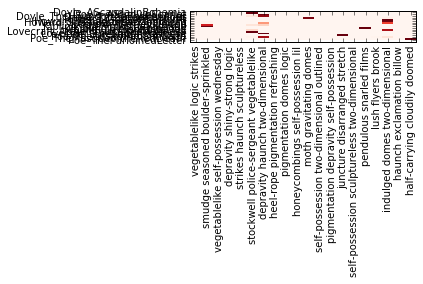

In [32]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

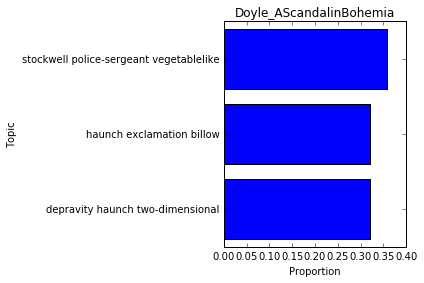

In [31]:
visual.plot_doc_topics(doc_topic, 0)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)